In [ ]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [ ]:
data_dir = pathlib.Path('./output/rgb')
# data_dir = pathlib.Path('./output/rgb_no_circle_det')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

In [ ]:
from skimage.feature import SIFT
from skimage import exposure
from skimage.color import rgb2gray, gray2rgb

def sift_features_vector(src, image_path, height_map=None):
    src = rgb2gray(src)
    img_adapteq = exposure.equalize_adapthist(src, clip_limit=0.03)
    print(img_adapteq.shape)
    descriptor_extractor = SIFT()
    # descriptor_extractor = ORB(n_keypoints=50)
    descriptor_extractor.detect_and_extract(img_adapteq)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    # random select 100 keypoints
    # random_keypoints = np.random.randint(0, len(keypoints), 50) 
    # random_keypoints = np.random.randint(0, len(keypoints), 200) # DMMP
    # random_keypoints = np.random.randint(0, len(keypoints), 500) # MP
    # random_keypoints = np.random.randint(0, len(keypoints), 1000) # MP
    random_keypoints = np.random.randint(0, len(keypoints), 2500) # for statics
    keypoints = keypoints[random_keypoints]
    descriptors = descriptors[random_keypoints]
    
    height_value = []
    if height_map is not None:
        for i in range(len(keypoints)):
            height = height_map[int(keypoints[i][0]), int(keypoints[i][1])]
            height_value.append(height)
    
    plt.imshow(img_adapteq, cmap='gray')
    plt.scatter(keypoints[:, 1], keypoints[:, 0],
                facecolors='none', edgecolors='r')
    plt.savefig('./output/sift/%s' % (image_path))
    plt.close()
    if height_map is not None:
        descriptors = np.hstack((descriptors, np.array(height_value).reshape(-1, 1)))
    print(descriptors.shape)
    return descriptors, keypoints

In [ ]:
def generate_height_map(size):
    # Define the radius of the sphere
    # offset = 0
    # offset = 175
    offset = 315
    size = size + 2*offset

    r = 1.0

    # Create a 2D grid of x and y coordinates
    x, y = np.meshgrid(np.linspace(-r, r, size), np.linspace(-r, r, size))

    # Calculate the corresponding z coordinates
    # Note: For points outside the sphere, this will be NaN
    z = np.sqrt(r**2 - x**2 - y**2)

    # We set points outside the sphere to zero height for visualization
    z[np.isnan(z)] = 0

    z = z[offset:size-offset, offset:size-offset]

    return z
# visualise the height map in 3D
height_map = generate_height_map(400)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the x, y, and z coordinate arrays. We use 
# numpy's broadcasting to do all the hard work for us.
# We could shorten this even more by using np.meshgrid.
x = np.arange(height_map.shape[0])
y = np.arange(height_map.shape[1])
x, y = np.meshgrid(x, y)
z = height_map

# Load the image
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('./output/rgb/M-DMMP- NaBF4-10-6M-1.jpg')
image = rgb2gray(image)
image = exposure.equalize_adapthist(image, clip_limit=0.03)
image = gray2rgb(image)
height, width = image.shape[:2]
resize_image = cv2.resize(src=image, dsize=(int(width / 2), int(height / 2)))
resize_image = resize_image[50:450, 50:450]

# Map the image to the surface
ax.plot_surface(x, y, z, facecolors=image, shade=False)

plt.show()

In [ ]:
import os
from sklearn.model_selection import train_test_split

rotation_aug = False

experiment_with_gray_scale = True

use_entire_dataset = True

load_all_images = False

use_height_map = True

distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, True

os.makedirs('./output/sift', exist_ok=True)

# Data selection
# molecular_imprinting_name = 'DMMP'
# molecular_imprinting_name = 'MP'
molecular_imprinting_name = 'MPA'
x = []
y = []
for path in data_dir.glob('*.jpg'):
    if not load_all_images:
        if path.name.split('-')[1] != molecular_imprinting_name and path.name.split('-')[1].split('(')[0] != molecular_imprinting_name:
                continue
    src = cv2.imread(str(path))
    height, width = src.shape[:2]
    center = (width / 2, height / 2)
    if rotation_aug:
        for i in range(3):
            rotation_matrix = rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=90 * i, scale=1)
            rotated_image = cv2.warpAffine(src=src, M=rotate_matrix, dsize=(width, height))
            resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
            # crop image 200x200
            resize_image = resize_image[150:350, 150:350]
            if use_height_map:
                height_map = generate_height_map(200)
                resize_image = np.dstack((resize_image.astype(np.float32), height_map))
            feature_vector = sift_features_vector(resize_image, os.path.basename(path))
            x.append(feature_vector)
            y.append(path.name.split('-')[2].replace(' ', ''))
    else:
        resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
        # crop image 200x200
        resize_image = resize_image[50:450, 50:450]
        if use_height_map:
            height_map = generate_height_map(400)
        else:
            height_map = None
        feature_vector, keypoints = sift_features_vector(resize_image, os.path.basename(path), height_map=height_map)
        x.append(keypoints)
        if load_all_images:
            label_name = path.name.split('-')[1].split('(')[0] + '-' + path.name.split('-')[2].replace(' ', '')
            if label_name.split('-')[0] != label_name.split('-')[1]:
                if distraction_merge or distraction_merge_to_one:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = label_name.split('-')[0] + '-distraction'
            elif label_name.split('-')[0] == label_name.split('-')[1]:
                if original_merge_to_one :
                    label_name = 'original'
        else:
            if distraction_merge or distraction_merge_to_one:
                if path.name.split('-')[2].split('(')[0] != molecular_imprinting_name:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = path.name.split('-')[1].split('(')[0] + '-distraction'
                else:
                    label_name = path.name.split('-')[2].replace(' ', '')
            else:
                label_name = path.name.split('-')[2].replace(' ', '')
        y.append(label_name)
        
x = np.array(x)
y = np.array(y)
print('data loaded x=%i' % (len(x)))
print('data loaded y=%i' % (len(y)))

In [ ]:
print(x.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x and y are defined properly
# x should be a list of arrays with shape (N, 2), where N is the number of keypoints
# y should be a list of strings corresponding to the labels of each point in x

# Corrected color map in RGB format
color_discrete_map = {
    "DMMP": [255, 0, 0],  # Red
    "NaBF4": [0, 255, 0],  # Green
    "KF6P": [0, 0, 255],  # Blue
    "MPA": [255, 165, 42],  # Goldenrod
    "MP": [128, 0, 128]  # Purple
}

fig = plt.figure(figsize=(10, 10))

# Ensure x and y have the same length
assert len(x) == len(y), "x and y must have the same length"

coordinates_color = {}

image_center = [200, 200]

angle_bin = 20

alignment = True

# Iterate over the keypoints
for i in range(len(x)):
    # Get the coordinates of the current keypoint
    coordinates = x[i]
    shifted_coordinates = coordinates - image_center
    
    # Calculate the angles and radii
    angles = np.arctan2(shifted_coordinates[:, 0], shifted_coordinates[:, 1])
    angles_in_degree = np.rad2deg(angles)
    radii = np.hypot(shifted_coordinates[:, 0], shifted_coordinates[:, 1])
    
    radii_filter_indices = np.where(radii <= 200)
    
    hist, edges = np.histogram(angles_in_degree, bins=angle_bin)
    angles_hist_min_index = np.argmin(hist)
    offset = edges[angles_hist_min_index]
    print('alignment found = %s' % offset)
    
    # rotate the coordinates based on offset
    rotation_matrix = np.array([
    [np.cos(np.deg2rad(offset)), -np.sin(np.deg2rad(offset))],
    [np.sin(np.deg2rad(offset)), np.cos(np.deg2rad(offset))]
    ])
    
    rotated_coordinates = np.dot(shifted_coordinates, rotation_matrix.T)
    
    if alignment:
        coordinates = rotated_coordinates[radii_filter_indices]
    else:
        coordinates = coordinates[radii_filter_indices]
        
    # Get the label for the current keypoint
    label = y[i]
    
    if label not in coordinates_color.keys():
        coordinates_color[label] = []

    # Get the color for the current label
    color = color_discrete_map[label]

    # Convert color to RGB format for matplotlib
    color_rgb = [c / 255.0 for c in color]

    coordinates_color[label].append(coordinates)

    # Scatter plot for keypoints
    plt.scatter(coordinates[:, 1], coordinates[:, 0], facecolors='none', edgecolors=color_rgb)

# Display the plot
plt.show()


In [ ]:
x.shape

In [ ]:
import plotly.io as pio

print(pio.templates)
pio.templates.default = 'plotly'

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Function to create a 3D histogram
def create_3d_histogram(keypoints, bins=(10, 10)):
    hist, edges = np.histogramdd(keypoints, bins=bins)
    total_sum = np.sum(hist)
    hist_normalized = hist / total_sum  # Normalize the histogram
    x_edges, y_edges = edges
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    x_mesh, y_mesh = np.meshgrid(x_centers, y_centers, indexing='ij')
    return x_mesh, y_mesh, hist_normalized, hist

# Create a figure
fig = go.Figure()

# Add each dataset's 3D density map to the figure
for label, keypoints in coordinates_color.items():
    keypoints_flat = np.vstack(keypoints)
    x_mesh, y_mesh, hist_norm, hist = create_3d_histogram(keypoints_flat)
    
    for i in range(len(x_mesh)):
        for j in range(len(y_mesh)):
            if np.hypot(x_mesh[i][j], y_mesh[i][j]) > 200:
                hist_norm[i][j] = np.nan

    fig.add_trace(go.Surface(
        x=x_mesh,
        y=y_mesh,
        z=hist_norm,
        name=label,
        visible=False  # Initially set all layers to invisible
    ))

# Set the first layer to be visible
fig.data[0].visible = True

# Create buttons to toggle the visibility of each layer
buttons = []
for i, label in enumerate(coordinates_color.keys()):
    button = dict(
        method='update',
        label=label,
        args=[{'visible': [j == i for j in range(len(coordinates_color))]},
              {'title': f'Overlapping 3D Density Maps - {label}'}]
    )
    buttons.append(button)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True
    }],
    title='Overlapping 3D Density Maps'
)

# Set labels
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Density'
    )
)

fig.update_layout(scene=dict(
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    zaxis=dict(showticklabels=False)
))

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=False))

fig.update_layout(autosize=False,
                  scene_camera_eye=dict(x=1.88, y=1.88, z=2.5),
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
)


fig.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Extract keypoints from x array
all_keypoints = np.vstack(x)

# Create a 3D histogram
hist, edges = np.histogramdd(all_keypoints, bins=(10, 10))

# Prepare the grid for plotting
x_edges, y_edges = edges
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Create a meshgrid for the centers
x_mesh, y_mesh = np.meshgrid(x_centers, y_centers, indexing='ij')

for i in range(len(x_mesh)):
        for j in range(len(y_mesh)):
            if np.hypot(x_mesh[i][j]-200, y_mesh[i][j]-200) > 200:
                hist[i][j] = np.nan

# Flatten the arrays for plotting
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
hist_flat = hist.ravel()


# Plot the 3D density map using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=x_flat,
    y=y_flat,
    z=hist_flat,
    mode='markers',
    marker=dict(
        size=5,
        color=hist_flat,
        colorscale='Viridis',
        colorbar=dict(title='Density')
    )
)])

# Set labels
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Density'
    ),
    title='3D Density Map'
)

fig.show()

In [ ]:
import math
import plotly.graph_objects as go


def barchart3d(labels, z_data, title, z_title, fig,
               n_row=0, width=900, height=900, thikness=0.7, colorscale='Viridis',
               **kwargs):
    """
    Draws a 3D barchart
    :param labels: Array_like of bar labels
    :param z_data: Array_like of bar heights (data coords)
    :param title: Chart title
    :param z_title: Z-axis title
    :param n_row: Number of x-rows
    :param width: Chart width (px)
    :param height: Chart height (px)
    :param thikness: Bar thikness (0; 1)
    :param colorscale: Barchart colorscale
    :param **kwargs: Passed to Mesh3d()
    :return: 3D barchart figure
    """

    if n_row < 1:
        n_row = math.ceil(math.sqrt(len(z_data)))
    thikness *= 0.5
    ann = []


    for iz, z_max in enumerate(z_data):
        x_cnt, y_cnt = iz % n_row, iz // n_row
        x_min, y_min = x_cnt - thikness, y_cnt - thikness
        x_max, y_max = x_cnt + thikness, y_cnt + thikness

        fig.add_trace(go.Mesh3d(
            x=[x_min, x_min, x_max, x_max, x_min, x_min, x_max, x_max],
            y=[y_min, y_max, y_max, y_min, y_min, y_max, y_max, y_min],
            z=[0, 0, 0, 0, z_max, z_max, z_max, z_max],
            alphahull=0,
            intensity=[0, 0, 0, 0, z_max, z_max, z_max, z_max],
            coloraxis='coloraxis',
            hoverinfo='skip',
            **kwargs))

        ann.append(dict(
            showarrow=False,
            x=x_cnt, y=y_cnt, z=z_max,
            text=f'<b>#{iz + 1}</b>',
            font=dict(color='white', size=11),
            bgcolor='rgba(0, 0, 0, 0.3)',
            xanchor='center', yanchor='middle',
            # hovertext=f'{z_max} {labels[iz]}'))
            ))

    # mesh3d doesn't currently support showLegend param, so
    # add invisible scatter3d with names to show legend
    # for i, label in enumerate(labels):
    #     fig.add_trace(go.Scatter3d(
    #         x=[None], y=[None], z=[None],
    #         opacity=0,
    #         name=f'#{i + 1} {label}'))

    fig.update_layout(
        width=width, height=height,
        title=title, title_x=0.5,
        scene=dict(
            xaxis=dict(showticklabels=False, title=''),
            yaxis=dict(showticklabels=False, title=''),
            zaxis=dict(title=z_title),),
        coloraxis=dict(
            colorscale=colorscale,
            colorbar=dict(
                title=dict(
                    text=z_title,
                    side='right'),
                xanchor='right', x=1.0,
                xpad=0,
                ticks='inside')),
        legend=dict(
            yanchor='top', y=1.0,
            xanchor='left', x=0.0,
            bgcolor='rgba(0, 0, 0, 0)',
            itemclick=False,
            itemdoubleclick=False),
        showlegend=True)


In [ ]:
import numpy as np
import plotly.graph_objects as go

for index in [0,1,2]:

    # Create a figure
    fig = go.Figure()
    
    
    label, keypoints = list(coordinates_color.items())[index]
    
    keypoints_flat = np.vstack(keypoints)
    x_mesh, y_mesh, hist_norm, hist = create_3d_histogram(keypoints_flat)
    
    # for i in range(len(x_mesh)):
    #     for j in range(len(y_mesh)):
    #         if np.hypot(x_mesh[i][j], y_mesh[i][j]) > 200:
    #             hist[i][j] = np.nan
    
    # Flatten the arrays for plotting
    x_flat = x_mesh.ravel()
    y_flat = y_mesh.ravel()
    hist_flat = hist.ravel()
    
    # Prepare labels and z_data for the barchart3d function
    labels = [f'({x}, {y})' for x, y in zip(x_flat, y_flat)]
    z_data = hist_flat.tolist()
    
    # Plot the 3D bar chart
    barchart3d(
        None, z_data,
        '', '', fig,
        colorscale='Viridis', opacity=0.6, flatshading=True,
    )
    
    
    fig.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1, y=1, z=2),
                      width=800, height=800,
                      margin=dict(l=65, r=50, b=65, t=90)
    )
    
    fig.update_layout(scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False)
    ))
    
    fig.update_coloraxes(showscale=False)
    
    fig.show()
    
    fig.write_image("output_density/%s-%s.png" % (molecular_imprinting_name, label), height=1000, width=1000)

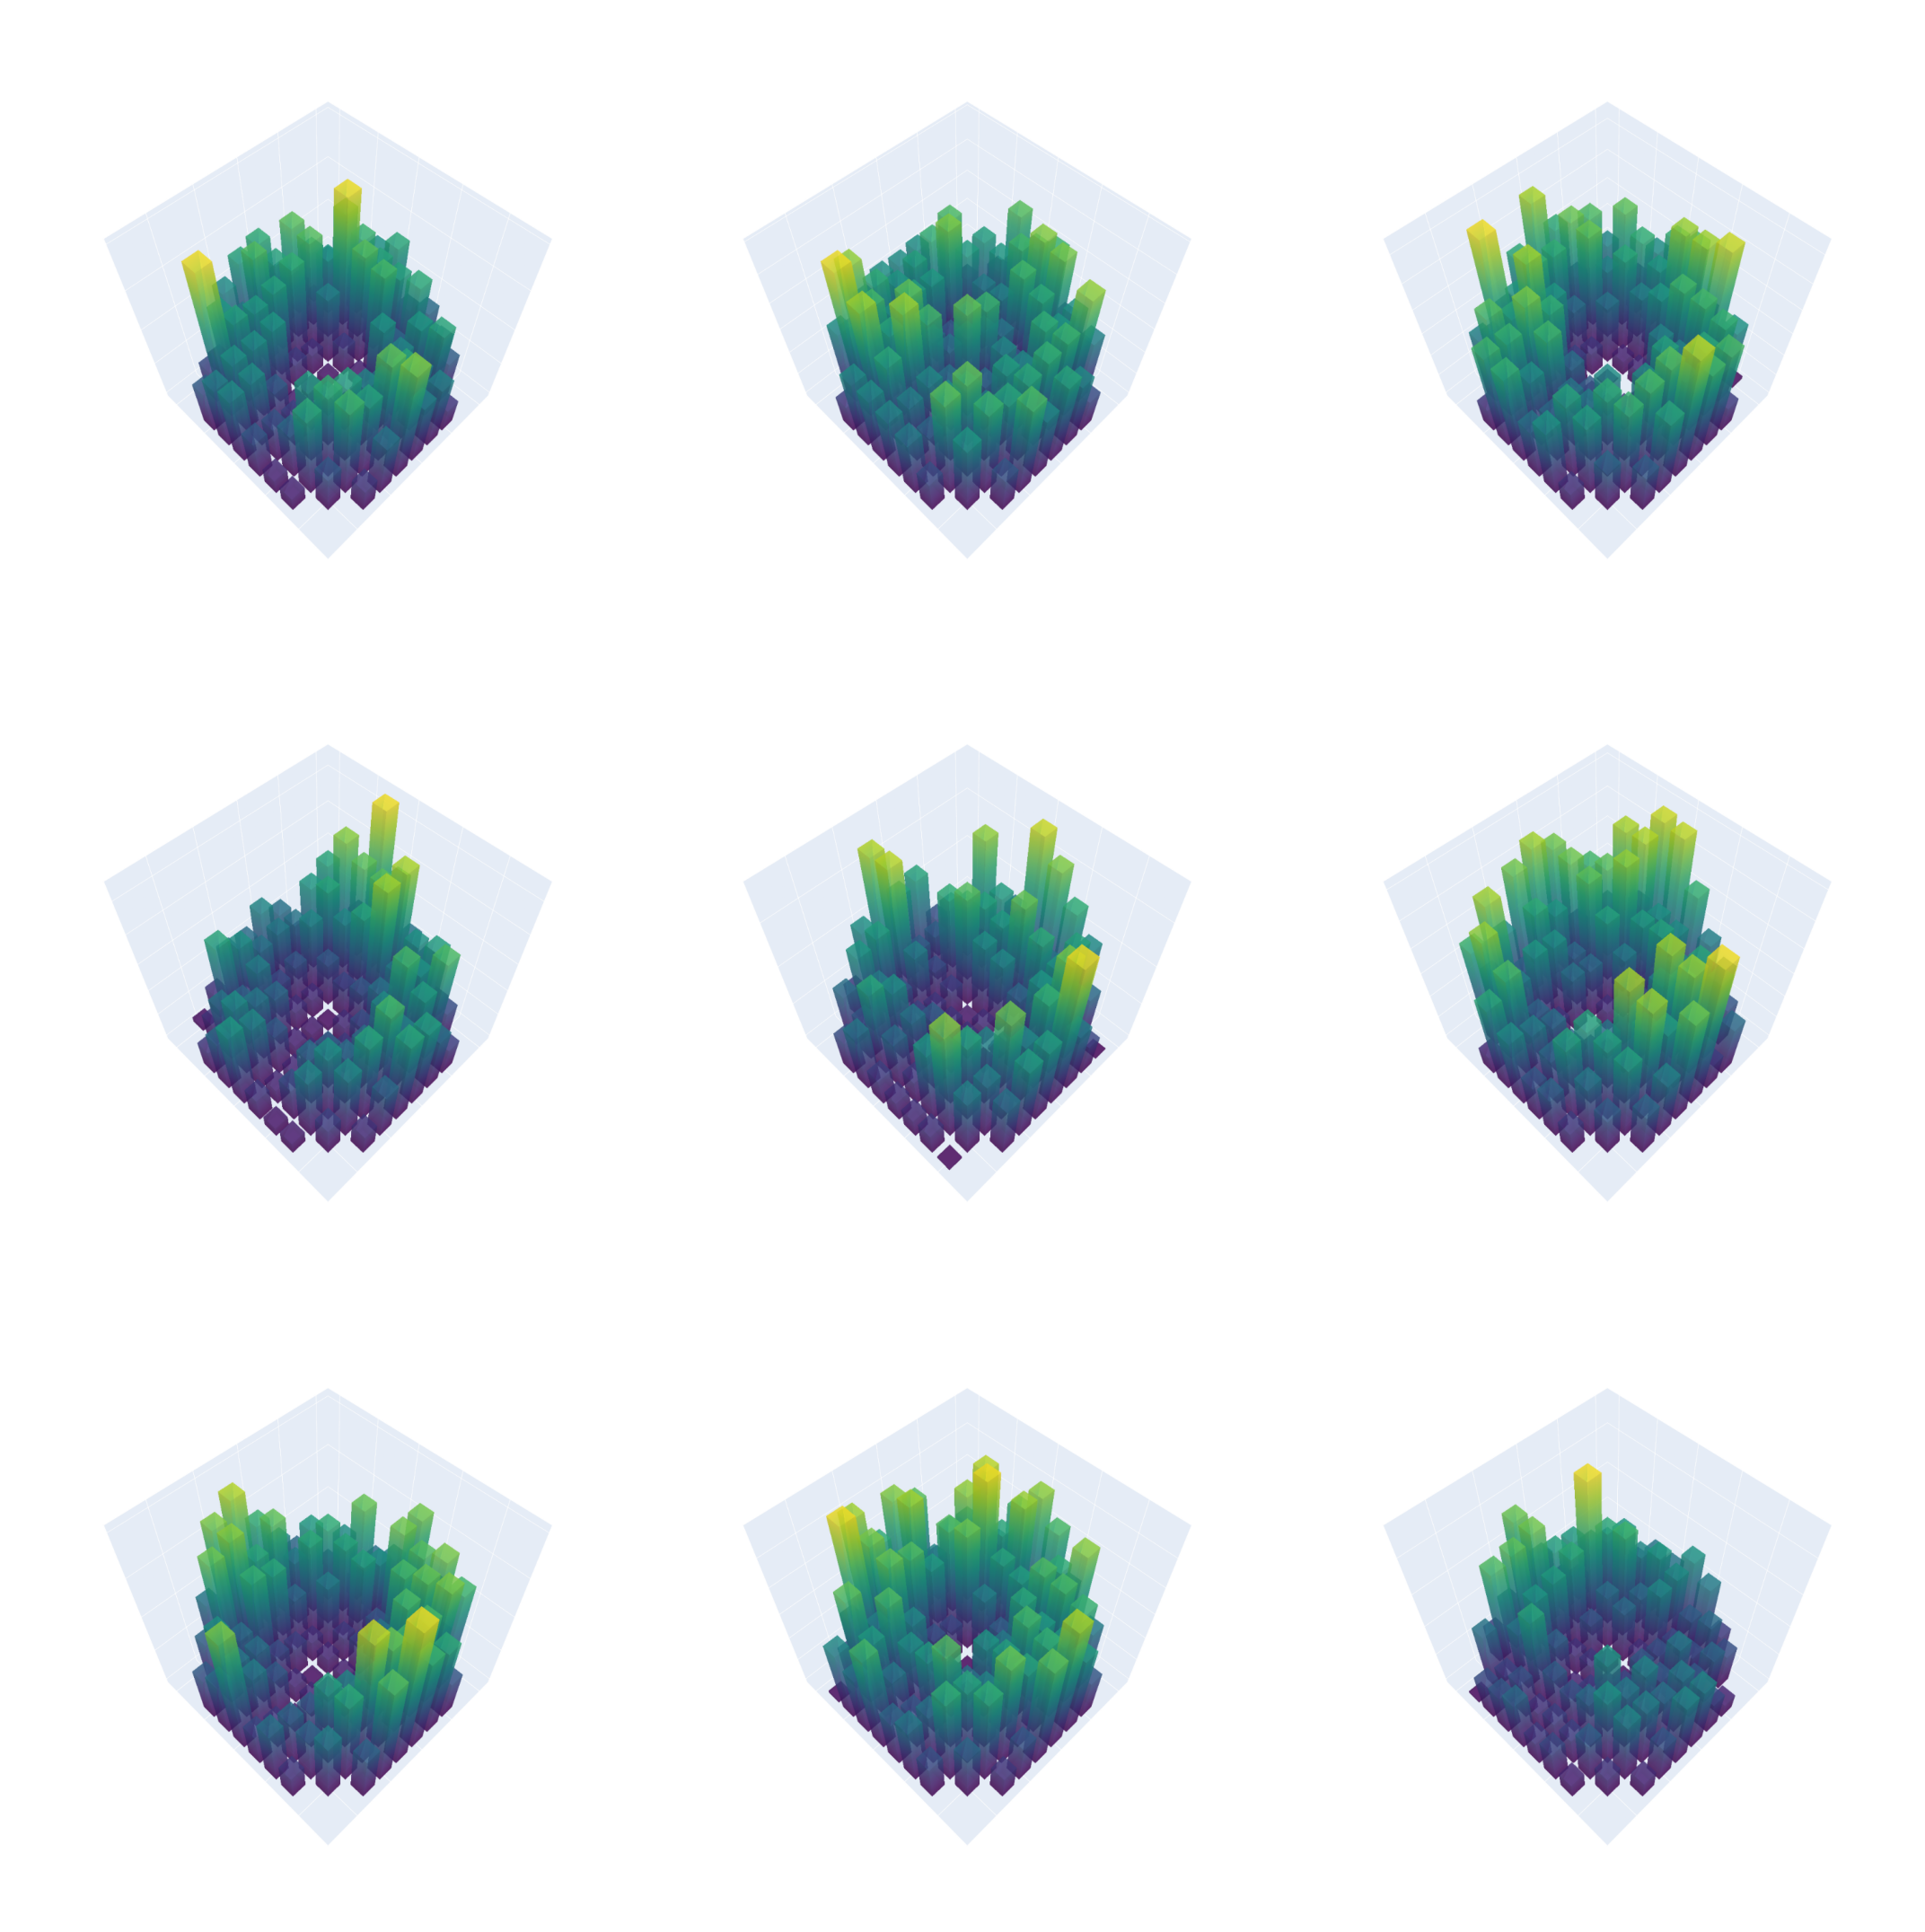

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image names
image_names = [
    'DMMP-DMMP', 'DMMP-NaBF4', 'DMMP-KF6P',
    'MP-MP', 'MP-NaBF4', 'MP-KF6P',
    'MPA-MPA', 'MPA-NaBF4', 'MPA-KF6P'
]

# Create a figure with a 3x3 grid layout
fig, axes = plt.subplots(3, 3, figsize=(30, 30))

# Loop through the image names and add each image to the grid
for i, ax in enumerate(axes.flat):
    img_path = f'./output_density/{image_names[i]}.png'
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Remove axis labels and ticks

# Set the background color to white
fig.patch.set_facecolor('white')

# Save the merged image
plt.tight_layout()
plt.savefig('./output_density/merged_image.png')
plt.show()